In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import pickle
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import itertools
import pandas as pd
import numpy as np
import os
import datetime
from datetime import datetime
from datetime import timedelta
from datetime import date

import scipy 
from scipy import optimize
import scipy.signal as signal 
import sys

    
sys.path.append('../../dsmuc/')
from dsmuc.custom import detect_peaks
import dsmuc.io as io
import dsmuc.preprocessing as pp
import dsmuc.features as ff
import dsmuc.custom as cs


import pytz
from azure.storage.blob import BlockBlobService
from io import StringIO
from azure.storage.blob import AppendBlobService
from azure.storage.blob import BlockBlobService
import requests
import json

label_dict = {1:'walking',
             2:'walking upstairs',
             3:'walking downstairs',
             4:'sitting',
             5:'standing',
             6:'laying',
             7:'unknown'}


# download_dir =  "../../data/G9_data/Downloaded"


# Model saved
filename = 'finalized_model.sav'
logreg = pickle.load(open(filename, 'rb'), encoding = 'iso-8859-1')


In [2]:
def time_to_str(t):
    t_woM = t.replace(microsecond=0)
    dt64 = np.datetime64(t_woM)
    a = dt64.astype('datetime64[s]')
    
    return np.datetime_as_string(a)+"Z"
def f(x):
    u, c = np.unique(x['predictions'].values, return_counts=True)
    outcome = u[np.argmax(c)]
    return outcome

In [21]:
##################
#### READ DATA ###
##################
day_now=0
day_before=1

account_name='watchstorage'
account_key='TJWcjsCs4aK9Xorw4DIAZGvKz0AFb2kvgSh49t+3nADR2usZ1ED14GLBQ/klJsSSrKykxu0ghCXn46+0bv2J8Q=='
container_name_ = 'jnj'

blob_service = BlockBlobService(account_name=account_name, account_key = account_key)


blobs = [];blob_date = []
generator = blob_service.list_blobs(container_name_)
for blob in generator:
    blobs.append(blob.name)
    blob_date.append(blob.name[:10])
blob_table = pd.DataFrame()
blob_table['date'] = blob_date
blob_table['blobname'] = blobs    
today = date.today().strftime('%Y-%m-%d')
yesterday = (date.today() - timedelta(1)).strftime('%Y-%m-%d')




In [22]:
blob_table

,date,blobname
0,2017-11-29,2017-11-29/861452078_35dbed8e8c614be8aebdb5b5d...
1,2017-11-29,2017-11-29/861452078_675bc4bf31d94968974e58c2a...
2,2017-11-30,2017-11-30/873240569_c3066418061948fdbc1f1fdcd...
3,2017-12-05,2017-12-05/873240569_6644c7aa2d104486b60aa0428...
4,2017-12-06,2017-12-06/873240569_34f3bf5800304afba5659dd3f...
5,2017-12-07,2017-12-07/873240569_4cd837cbf09141be8211a802d...
6,2017-12-08,2017-12-08/873240569_3a862ff4cf5c40f08c26524da...
7,2017-12-11,2017-12-11/873240569_231439354b5a46ada32e77abe...
8,2017-12-12,2017-12-12/873240569_075dc9e3d8ea4e9b8647d834e...
9,2017-12-13,2017-12-13/873240569_b4a0e0c810ae426aac376cefa...


In [23]:
blob_table = blob_table[blob_table['date']=='2018-06-28']
blob_table

,date,blobname
113,2018-06-28,2018-06-28/873240569_e867e2341df34a8b9e6e5f81b...


In [25]:
yesterday = '2018-06-27'
today = '2018-06-28'

In [26]:
%%time
if blob_table.shape[0]>0:
    blob_df = pd.DataFrame()
    # blobname is the csv
    for blobname in blob_table['blobname']:
        blob_Class = blob_service.get_blob_to_text(container_name=container_name_, blob_name = blobname)
        blob_String =blob_Class.content
        
        for chunk in pd.read_csv(StringIO(blob_String), chunksize=10000):
            blob_df = blob_df.append(chunk)

    print("READ DATA FRAMES SIZE :",blob_df.shape[0])


READ DATA FRAMES SIZE : 13616441
CPU times: user 6min 53s, sys: 4min 11s, total: 11min 4s
Wall time: 14min 40s


In [27]:
blob_df['id'].unique()[::-1]

array(['watch-sensor-356969030313296', 'watch-sensor-356969030413245'],
      dtype=object)

Watch  watch-sensor-356969030313296  is being processed


/anaconda/envs/py35/lib/python3.5/site-packages/dsmuc/custom/__init__.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  df['date'] = pd.to_datetime(df[unix_col],unit=unit)


Extracting interested sensor data...
READ DATA FRAMES SIZE AFTER CLEANING : 100366
doing time: 2018-06-27 00:00:00  -  2018-06-27 00:05:00
doing time: 2018-06-27 00:05:00  -  2018-06-27 00:10:00
doing time: 2018-06-27 00:10:00  -  2018-06-27 00:15:00
doing time: 2018-06-27 00:15:00  -  2018-06-27 00:20:00
doing time: 2018-06-27 00:20:00  -  2018-06-27 00:25:00
doing time: 2018-06-27 00:25:00  -  2018-06-27 00:30:00
doing time: 2018-06-27 00:30:00  -  2018-06-27 00:35:00
doing time: 2018-06-27 00:35:00  -  2018-06-27 00:40:00
doing time: 2018-06-27 00:40:00  -  2018-06-27 00:45:00
doing time: 2018-06-27 00:45:00  -  2018-06-27 00:50:00
doing time: 2018-06-27 00:50:00  -  2018-06-27 00:55:00
doing time: 2018-06-27 00:55:00  -  2018-06-27 01:00:00
doing time: 2018-06-27 01:00:00  -  2018-06-27 01:05:00
doing time: 2018-06-27 01:05:00  -  2018-06-27 01:10:00
doing time: 2018-06-27 01:10:00  -  2018-06-27 01:15:00
doing time: 2018-06-27 01:15:00  -  2018-06-27 01:20:00
doing time: 2018-06-2

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:12: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  if sys.path[0] == '':
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel_launcher.py:15: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  from ipykernel import kernelapp as app


doing time: 2018-06-27 01:50:00  -  2018-06-27 01:55:00
doing time: 2018-06-27 01:55:00  -  2018-06-27 02:00:00
doing time: 2018-06-27 02:00:00  -  2018-06-27 02:05:00
doing time: 2018-06-27 02:05:00  -  2018-06-27 02:10:00
doing time: 2018-06-27 02:10:00  -  2018-06-27 02:15:00
doing time: 2018-06-27 02:15:00  -  2018-06-27 02:20:00
doing time: 2018-06-27 02:20:00  -  2018-06-27 02:25:00
doing time: 2018-06-27 02:25:00  -  2018-06-27 02:30:00
doing time: 2018-06-27 02:30:00  -  2018-06-27 02:35:00
doing time: 2018-06-27 02:35:00  -  2018-06-27 02:40:00
doing time: 2018-06-27 02:40:00  -  2018-06-27 02:45:00
doing time: 2018-06-27 02:45:00  -  2018-06-27 02:50:00
doing time: 2018-06-27 02:50:00  -  2018-06-27 02:55:00
doing time: 2018-06-27 02:55:00  -  2018-06-27 03:00:00
doing time: 2018-06-27 03:00:00  -  2018-06-27 03:05:00
doing time: 2018-06-27 03:05:00  -  2018-06-27 03:10:00
doing time: 2018-06-27 03:10:00  -  2018-06-27 03:15:00
doing time: 2018-06-27 03:15:00  -  2018-06-27 0

/anaconda/envs/py35/lib/python3.5/site-packages/dsmuc/features/__init__.py:166: RuntimeWarning: Mean of empty slice.
  list_.append(np.diff(ind).mean())
/anaconda/envs/py35/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


doing time: 2018-06-27 06:20:00  -  2018-06-27 06:25:00
doing time: 2018-06-27 06:25:00  -  2018-06-27 06:30:00
doing time: 2018-06-27 06:30:00  -  2018-06-27 06:35:00
doing time: 2018-06-27 06:35:00  -  2018-06-27 06:40:00
doing time: 2018-06-27 06:40:00  -  2018-06-27 06:45:00
doing time: 2018-06-27 06:45:00  -  2018-06-27 06:50:00
doing time: 2018-06-27 06:50:00  -  2018-06-27 06:55:00
doing time: 2018-06-27 06:55:00  -  2018-06-27 07:00:00
doing time: 2018-06-27 07:00:00  -  2018-06-27 07:05:00
doing time: 2018-06-27 07:05:00  -  2018-06-27 07:10:00
doing time: 2018-06-27 07:10:00  -  2018-06-27 07:15:00
doing time: 2018-06-27 07:15:00  -  2018-06-27 07:20:00
doing time: 2018-06-27 07:20:00  -  2018-06-27 07:25:00
doing time: 2018-06-27 07:25:00  -  2018-06-27 07:30:00
doing time: 2018-06-27 07:30:00  -  2018-06-27 07:35:00
doing time: 2018-06-27 07:35:00  -  2018-06-27 07:40:00
doing time: 2018-06-27 07:40:00  -  2018-06-27 07:45:00
doing time: 2018-06-27 07:45:00  -  2018-06-27 0

doing time: 2018-06-27 19:50:00  -  2018-06-27 19:55:00
doing time: 2018-06-27 19:55:00  -  2018-06-27 20:00:00
doing time: 2018-06-27 20:00:00  -  2018-06-27 20:05:00
doing time: 2018-06-27 20:05:00  -  2018-06-27 20:10:00
doing time: 2018-06-27 20:10:00  -  2018-06-27 20:15:00
doing time: 2018-06-27 20:15:00  -  2018-06-27 20:20:00
doing time: 2018-06-27 20:20:00  -  2018-06-27 20:25:00
doing time: 2018-06-27 20:25:00  -  2018-06-27 20:30:00
doing time: 2018-06-27 20:30:00  -  2018-06-27 20:35:00
doing time: 2018-06-27 20:35:00  -  2018-06-27 20:40:00
doing time: 2018-06-27 20:40:00  -  2018-06-27 20:45:00
doing time: 2018-06-27 20:45:00  -  2018-06-27 20:50:00
doing time: 2018-06-27 20:50:00  -  2018-06-27 20:55:00
doing time: 2018-06-27 20:55:00  -  2018-06-27 21:00:00
doing time: 2018-06-27 21:00:00  -  2018-06-27 21:05:00
doing time: 2018-06-27 21:05:00  -  2018-06-27 21:10:00
doing time: 2018-06-27 21:10:00  -  2018-06-27 21:15:00
doing time: 2018-06-27 21:15:00  -  2018-06-27 2

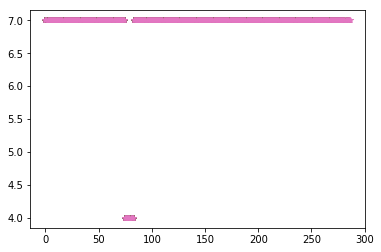

success uploading watch data
Watch  watch-sensor-356969030413245  is being processed
Extracting interested sensor data...
READ DATA FRAMES SIZE AFTER CLEANING : 1603016
doing time: 2018-06-27 00:00:00  -  2018-06-27 00:05:00
doing time: 2018-06-27 00:05:00  -  2018-06-27 00:10:00
doing time: 2018-06-27 00:10:00  -  2018-06-27 00:15:00
doing time: 2018-06-27 00:15:00  -  2018-06-27 00:20:00
doing time: 2018-06-27 00:20:00  -  2018-06-27 00:25:00
doing time: 2018-06-27 00:25:00  -  2018-06-27 00:30:00
doing time: 2018-06-27 00:30:00  -  2018-06-27 00:35:00
doing time: 2018-06-27 00:35:00  -  2018-06-27 00:40:00
doing time: 2018-06-27 00:40:00  -  2018-06-27 00:45:00
doing time: 2018-06-27 00:45:00  -  2018-06-27 00:50:00
doing time: 2018-06-27 00:50:00  -  2018-06-27 00:55:00
doing time: 2018-06-27 00:55:00  -  2018-06-27 01:00:00
doing time: 2018-06-27 01:00:00  -  2018-06-27 01:05:00
doing time: 2018-06-27 01:05:00  -  2018-06-27 01:10:00
doing time: 2018-06-27 01:10:00  -  2018-06-27 

KeyboardInterrupt: 

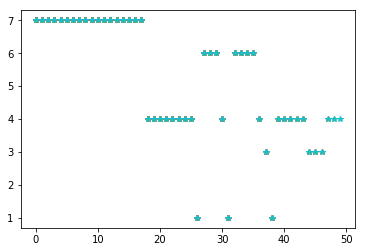

In [28]:
feature_list =  ['aoa','ate','apf','rms','std','minimax','cor','mean','min','max']
preserved_features=['start']


for watch_id in blob_df['id'].unique()[::-1]:
    print("Watch ", watch_id," is being processed" )
    df_temp = io.read_g9(blob_df[blob_df['id']==watch_id], sort=False)
    df_temp = df_temp.drop_duplicates(keep='last')[::2].sort_index()
    print("READ DATA FRAMES SIZE AFTER CLEANING :",df_temp.shape[0])
    # Time to do analysis is specified
    start = yesterday + 'T00:00:00.0000Z'
    start_temp = np.datetime64(start)
    t = pd.Timestamp(start_temp)
    end = today + 'T00:00:00.0000Z'
    end_temp = np.datetime64(end)
    end_time = pd.Timestamp(end_temp)

    # Initialize 
    whole_window_size = timedelta(minutes = 5)
    window_size = timedelta(seconds=2)
    window_slide = timedelta(seconds=1)
    samples_count = []
    a = 0
    df_out = pd.DataFrame()
    t_start_list = []
    t_end_list = []
    outcome_list = []
    while (t + whole_window_size < end_time):
        label_list = []
        increment = 0
        DF = pd.DataFrame()
        t_end5min= t + whole_window_size 
        print("doing time:",t, ' - ', t_end5min)
        t_start_list.append(time_to_str(t))
        t_end_list.append(time_to_str(t_end5min))
        if df_temp.between_time(t.to_pydatetime().time(), t_end5min.to_pydatetime().time()\
                                           ,include_start=True, include_end=False).shape[0] >= 10:


            while(t+window_slide< t_end5min):
                t_end = t + window_size
                snippet_df = df_temp.between_time(t.to_pydatetime().time(), t_end.to_pydatetime().time()
                                               ,include_start=True, include_end=False)
                if snippet_df.shape[0]>= 20:
                    increment +=1
                    ser = ff.extract_features(snippet_df, index=increment, feature_list=feature_list ,\
                                preserved_features=preserved_features)
                    DF = DF.append(ser)
                t = t_end
        else:
            t = t_end5min

        if DF.shape[0]<=11:
            outcome = 7.0
        else:
            df_X = DF.set_index(pd.DatetimeIndex(DF['start'])).drop('start' ,axis =1)
            del DF 
            df_X.fillna(df_X.mean().fillna(0), inplace=True)
            X_test = df_X.values
            y_pred = logreg.predict(X_test)                
            u, c = np.unique(y_pred, return_counts=True)
            outcome = u[np.argmax(c)]
        outcome_list.append(label_dict[int(outcome)])
        out_ser = pd.Series(outcome,name=(t-whole_window_size, t) )
        df_out = df_out.append(out_ser)
        plt.plot(list(range(df_out.shape[0])), df_out[0], "*")
        ## Send predictions 
    plt.show()   
    
    # Create the json string to upload 
    dict_list = []
    for i in range(len(outcome_list)):
        payload_dict = {'address':watch_id.split("-")[2],
             'starttime':t_start_list[i],
             'endtime':t_end_list[i],
             'tasklocation':'Activity',
             'taskname':outcome_list[i],
             'name':outcome_list[i],
             'value':1}
        dict_list.append(payload_dict)
    payload = json.dumps(dict_list)
    url = "https://colife-dashboard.silverline.mobi/uploadActivityLabelForSmartWatch"
    headers = {
        'content-type': "application/json",
        'cache-control': "no-cache",
        'postman-token': "87b2b04f-175f-4a9b-f2c8-bf31de2cae7d"
        }
    # Send the data 
    response = requests.request("POST", url, data=payload, headers=headers)
    print(response.text)

